# Spherical latent space model for Networks: Model $\mathbb{S}^1$

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from Modules.SphericalM import *
from Modules.SphericalV import *
from Modules.SphericalC import *

## Network

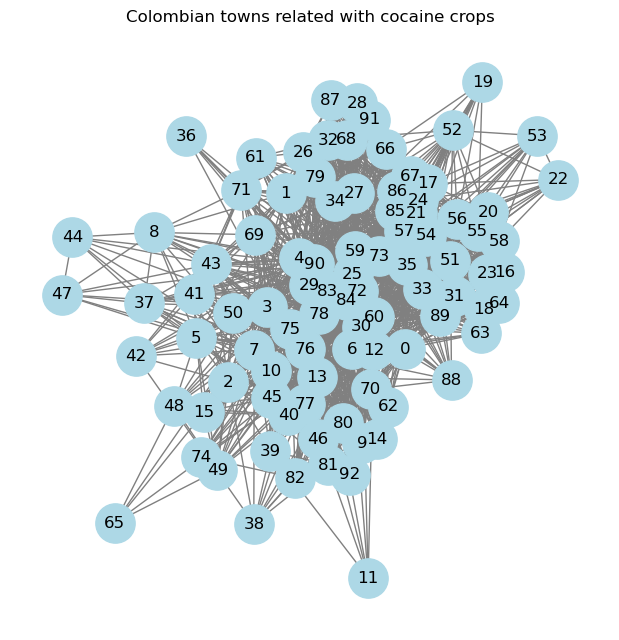

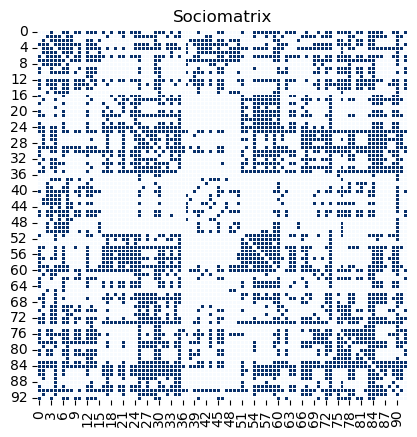

In [2]:
Y = np.loadtxt("colombiancropmatrix.txt", delimiter="\t")  
G = nx.from_numpy_array(Y)

node_mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, node_mapping)
n = len(G.nodes)
plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Colombian towns related with cocaine crops")
plt.show()

Y = nx.to_numpy_array(G, dtype=float)

sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Sociomatrix")
plt.show()

## Latent space

### Frequentist inference

Initial log-likelihood: -5800.0768791766
Final log-likelihood: -5690.138851484973
Final alpha: -0.44138859165429944


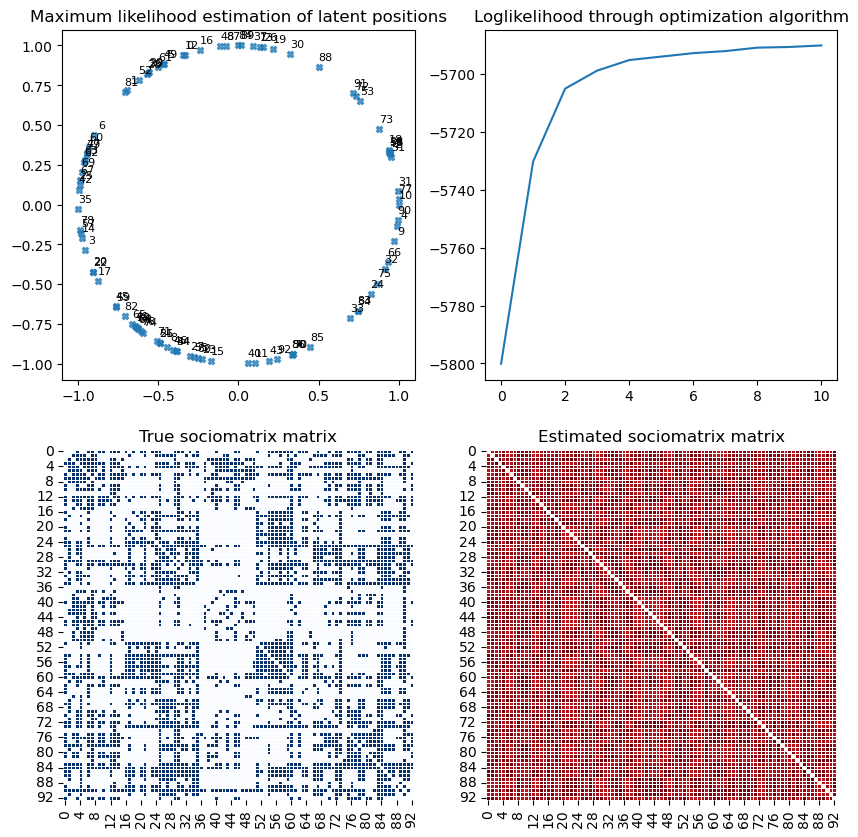

In [4]:

angles_rand = 2*np.pi*np.random.rand(n)
Z_init = np.stack((np.cos(angles_rand), np.sin(angles_rand)), axis=1)
a_init = np.float64(np.random.randn())
b_init = np.float64(np.random.randn())
Z_ML, a_ML, b_ML, historyZ, historya, historyb  =  SearchingMLE(G,Z_init,a_init,b_init,10)
print("Initial log-likelihood:", loglikelihood(G,Z_init,a_init, b_init))
print("Final log-likelihood:", loglikelihood(G,Z_ML,a_ML,b_ML))
print("Final alpha:", a_ML)
Y_ML = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            d = Z_ML[i].T @ Z_ML[j]
            Y_ML[i,j] = expit(a_ML + b_ML*d)


plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.scatter(Z_ML[:, 0], Z_ML[:, 1], s=20, alpha=0.7,marker="X")
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
for i, (x, y) in enumerate(Z_ML):
    plt.annotate(str(i), (x, y), textcoords="offset points", xytext=(5,5), ha='center', fontsize=8)
plt.title("Maximum likelihood estimation of latent positions")
plt.subplot(2,2,2)
plt.plot([loglikelihood(G, historyZ[t],historya[t],historyb[t]) for t in range(len(historya))])
plt.title("Loglikelihood through optimization algorithm")
plt.subplot(2,2,3)
sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(2,2,4)
sns.heatmap(Y_ML, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Estimated sociomatrix matrix")
plt.show()

### Bayesian inference

In [4]:
# Execute HMC
number_of_samples = 2500
Z_init = Z_ML.copy()
a_init = a_ML
b_init = b_ML


print("Log-L MLE:", loglikelihood(G,Z_ML,a_ML,b_ML))
print("Log-L starter:", loglikelihood(G,Z_init,a_init,b_init))

samples_Z, samples_a, samples_b, Hp, LogLp, acep_rate_history = ghmc(G, Z_init, a_init, b_init, number_of_samples, epsilon_init=0.025, 
                                                                     std_dev_init_Z=0.2, std_dev_init_a = 1.0, std_dev_init_b = 0.5, 
                                                                     percentage_warmup=0.2)
samples_Z = [compute_starS1(samples_Z[i],Z_ML) for i in range(len(samples_Z))]
samples_Z = np.array(samples_Z)
# Estimators
## CM
from scipy.stats import circmean
angles_CM = circmean(np.arctan2(samples_Z[:, :, 1], samples_Z[:, :, 0]), high=2*np.pi, low=0,axis=0)
Z_CM =  np.stack((np.cos(angles_CM), np.sin(angles_CM)), axis=1)
a_CM = np.mean(samples_a, axis=0)
b_CM = np.mean(samples_b, axis=0)
## MAP
Z_MAP = samples_Z[np.argmin(Hp),:,:]
a_MAP = samples_a[np.argmin(Hp)]
b_MAP = samples_b[np.argmin(Hp)]


print("Log-L MAP:", loglikelihood(G,Z_MAP,a_MAP,b_MAP))
print("Log-L CM:", loglikelihood(G,Z_CM,a_CM,b_CM))

Log-L MLE: -75.34107656354628
Log-L starter: -75.34107656354628
Number of samples: 2500
Number of parameters: 17
Number of iterations: 3000
Number of warmup iterations: 500


 17%|█▋        | 500/3000 [10:52<43:00,  1.03s/it]  

Final parameters: epsilon=0.0250, L=40, std_dev_Z=0.1783, std_dev_a=1.0000, std_dev_b=0.5000


100%|██████████| 3000/3000 [43:37<00:00,  1.15it/s]  


Acceptance rate: 0.79873
Log-L MAP: -71.54736355554554
Log-L CM: -88.15006033541567


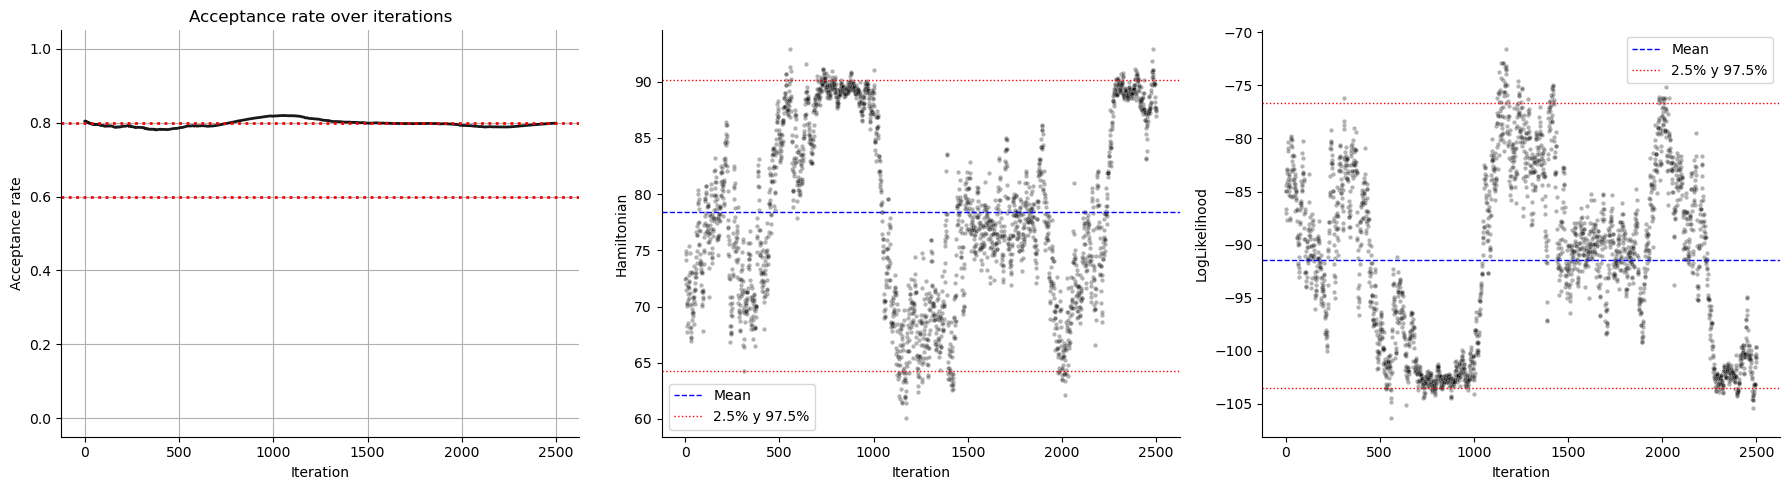

In [5]:
plot_diagnostics(Hp,LogLp,acep_rate_history)

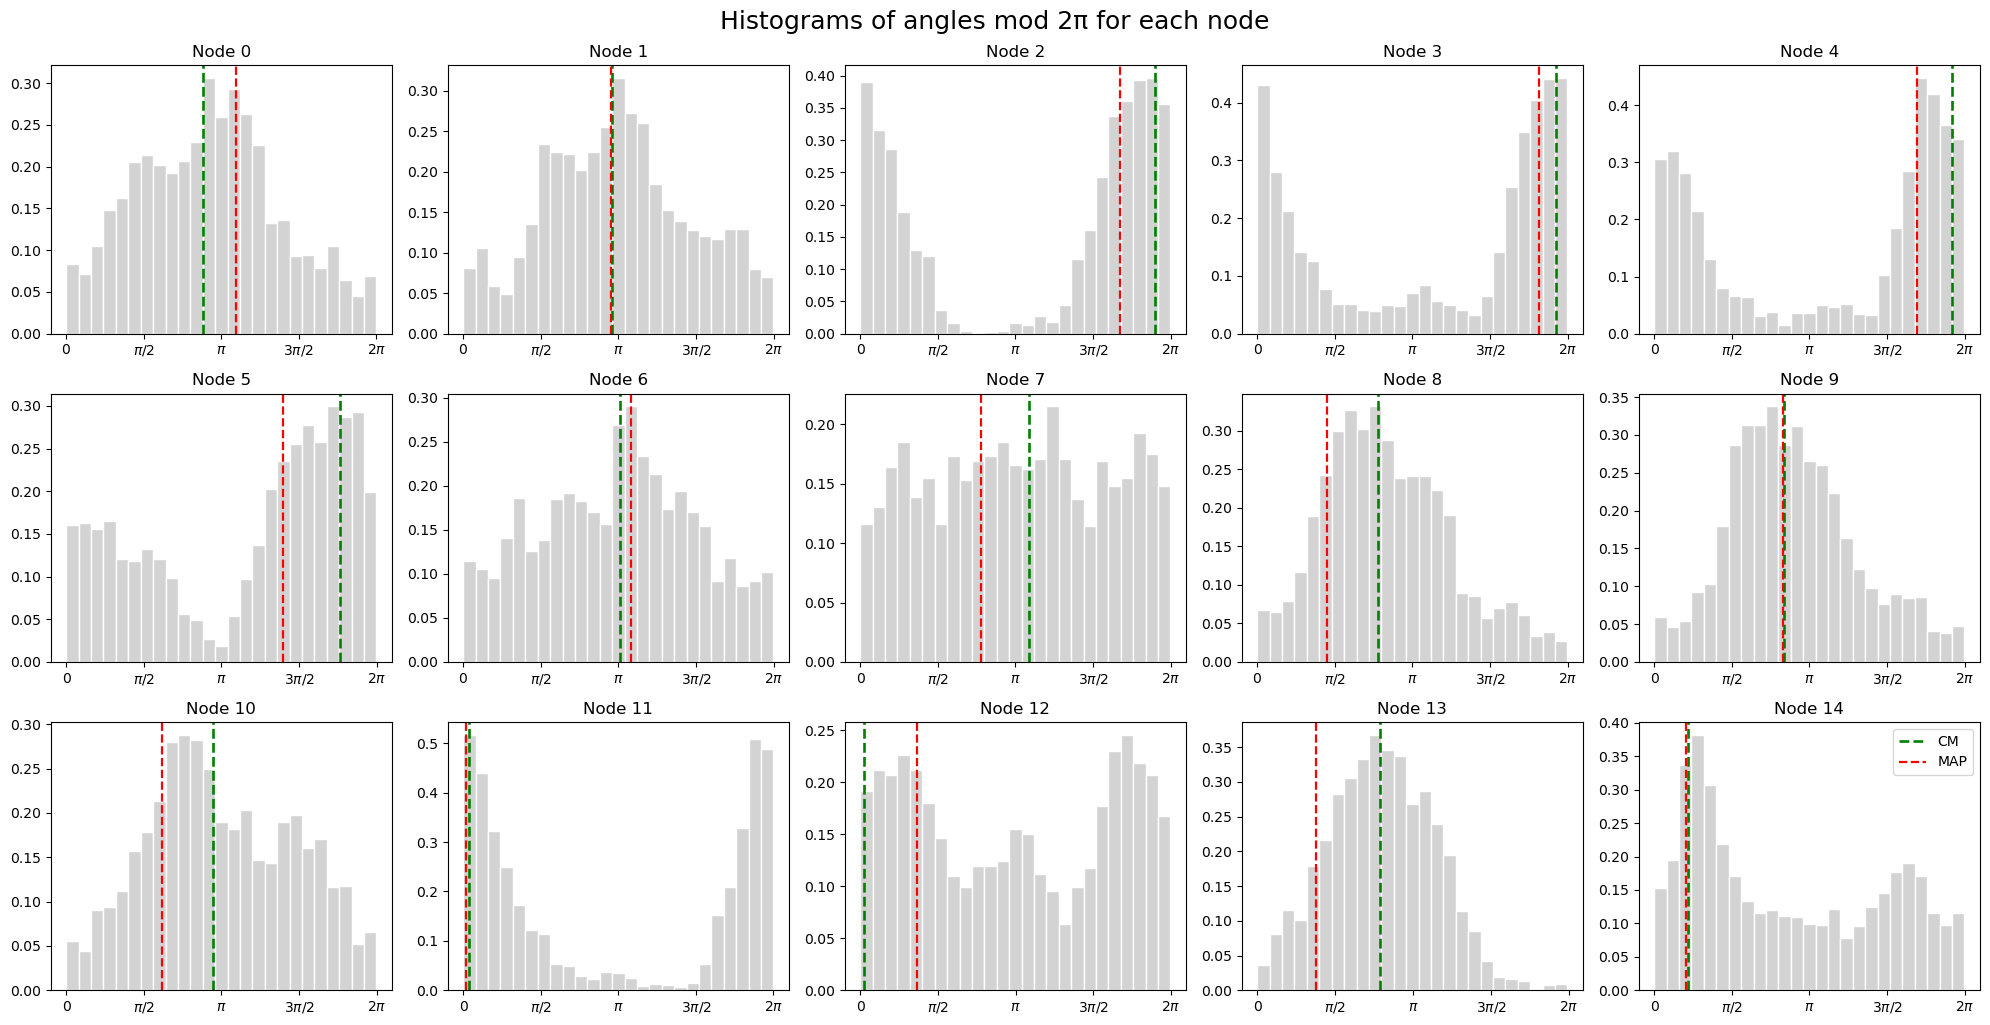

In [6]:
fig, axes = plt.subplots(3, 5, figsize=(20, 10)) 
axes = axes.flatten() 

for i in range(n):
    ax = axes[i]
    angles = np.mod(np.arctan2(samples_Z[:, i, 1], samples_Z[:, i, 0]), 2*np.pi)
    
    ax.hist(angles, bins=25, color='lightgray', edgecolor='white', density=True)
    ax.axvline(np.mod(np.arctan2(Z_CM[i, 1], Z_CM[i, 0]), 2*np.pi), color='green', linestyle='dashed', linewidth=1.9)
    ax.axvline(np.mod(np.arctan2(Z_MAP[i, 1], Z_MAP[i, 0]), 2*np.pi), color='red', linestyle='dashed', linewidth=1.6)
    ax.set_title(f'Node {i}')
    ax.set_xticks([0, np.pi/2, np.pi , 3*np.pi/2, 2*np.pi])
    ax.set_xticklabels(['0', r'$\pi/2$', r'$\pi$', r'$3\pi/2$',r'$2\pi$'])
    ax.grid(False)
plt.legend(['CM','MAP'], loc='upper right')
plt.tight_layout()
plt.suptitle("Histograms of angles mod 2π for each node", y=1.02, fontsize=18) 
plt.show()

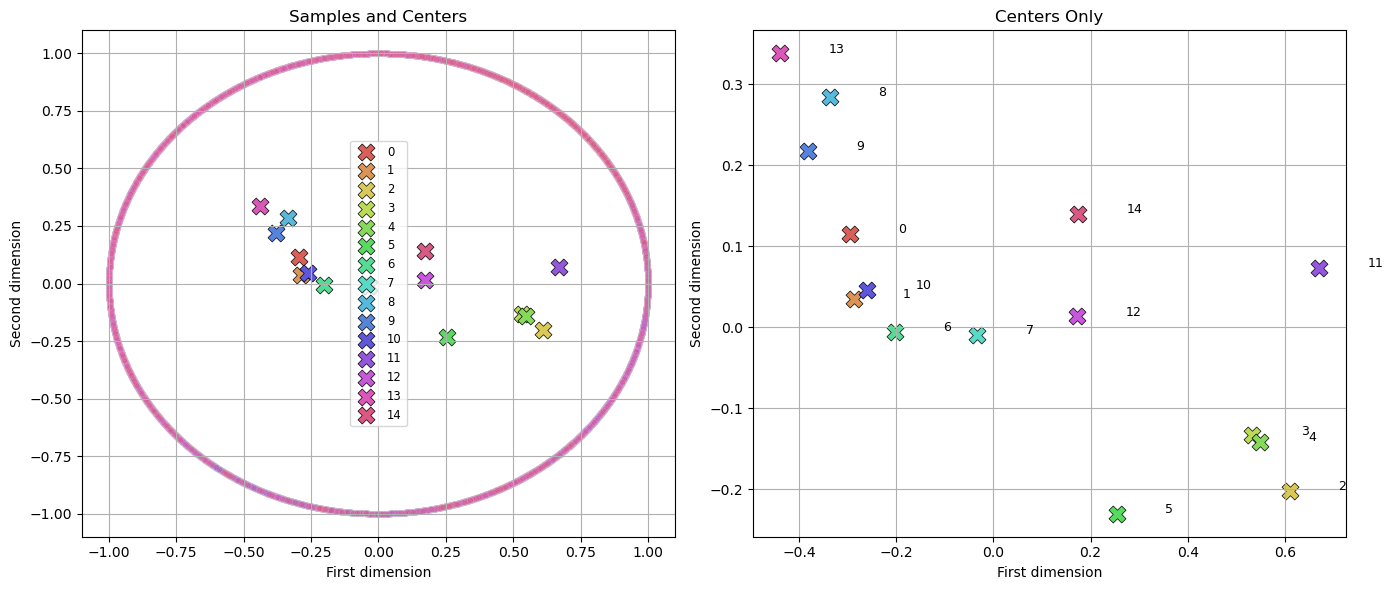

In [7]:
plot_Z_samples_2D(samples_Z)

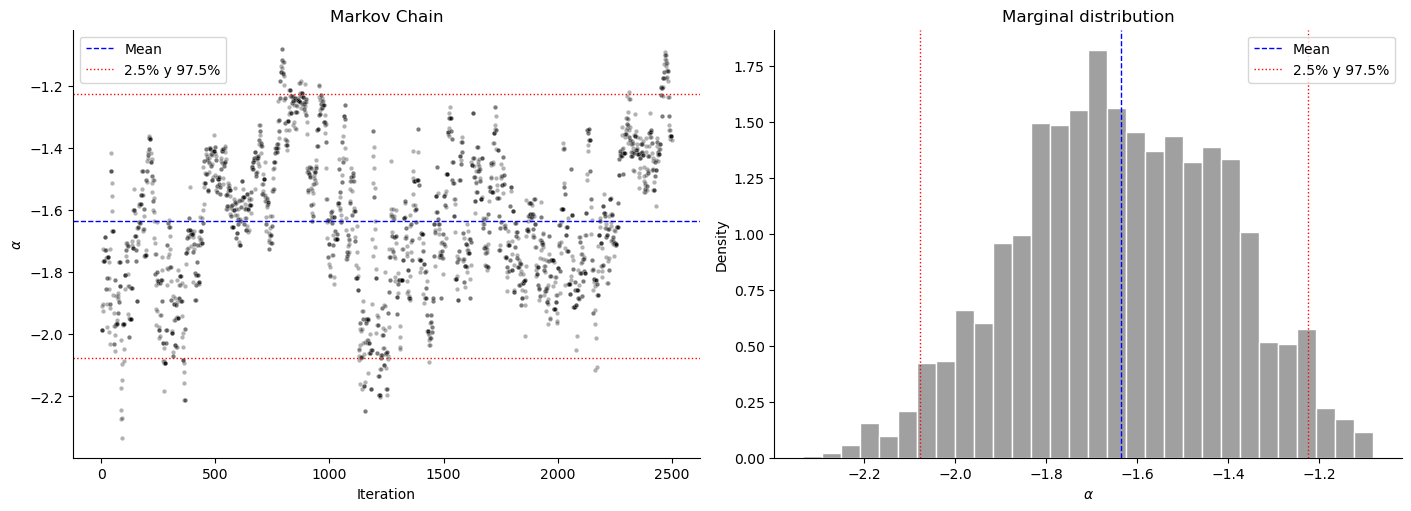

In [8]:
plot_alpha(samples_a)

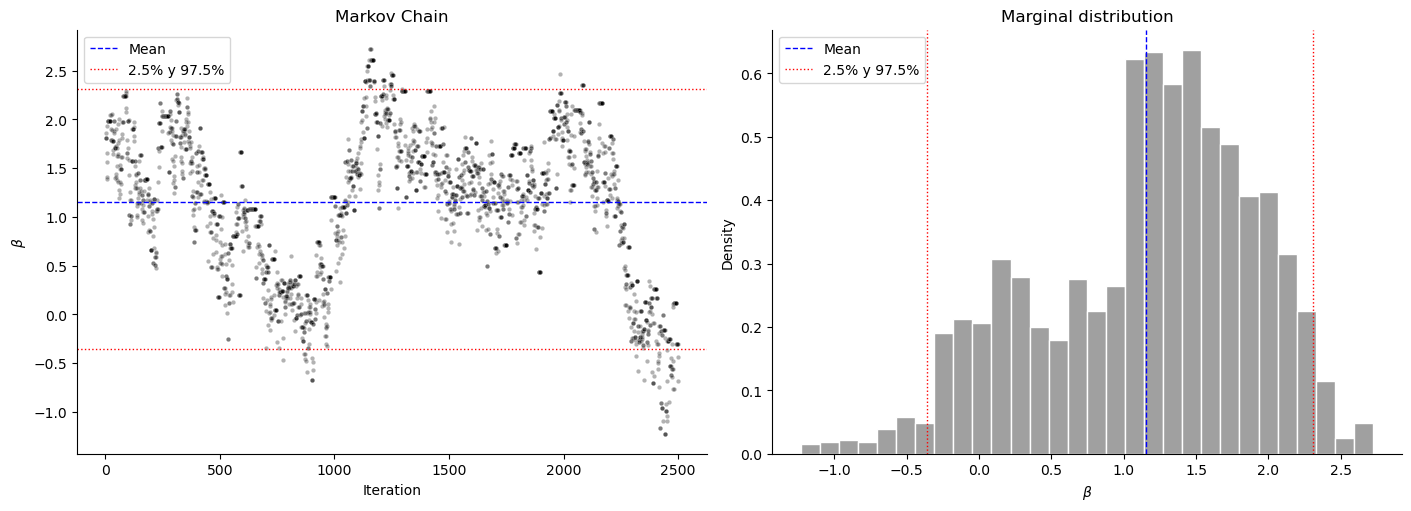

In [9]:
plot_beta(samples_b)

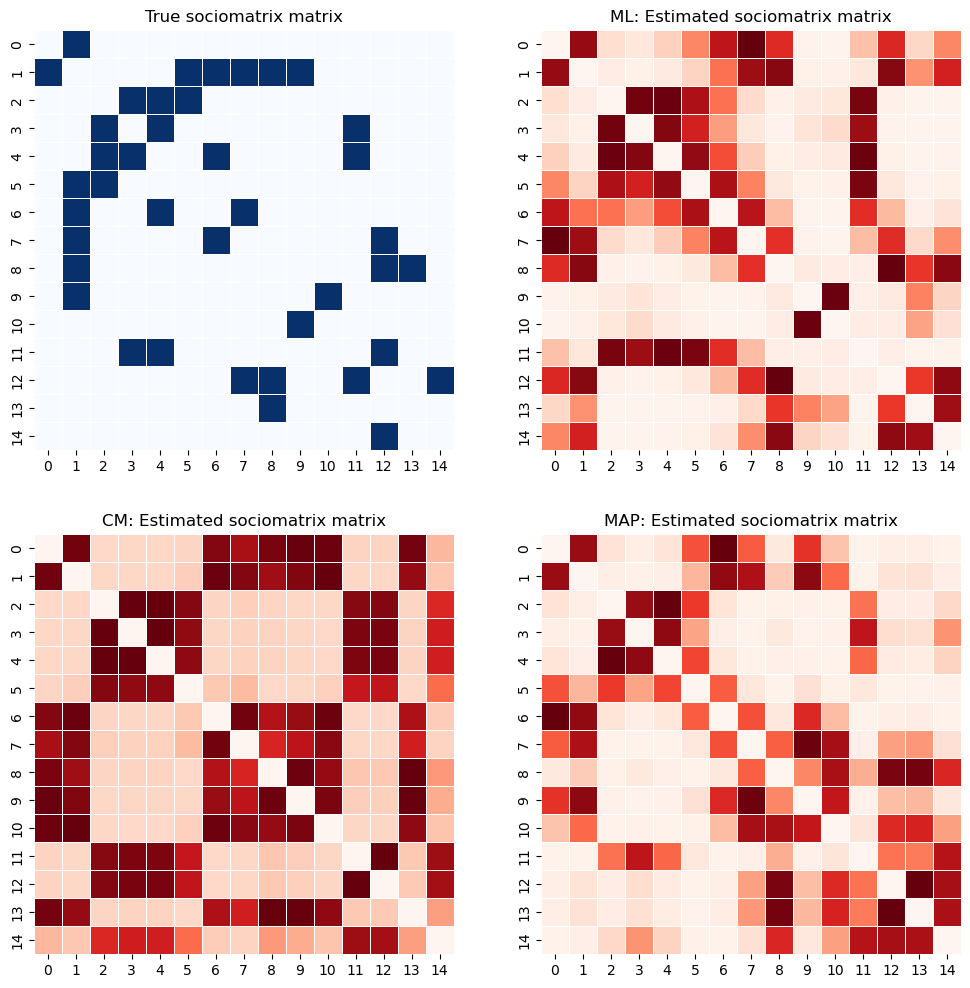

In [10]:
Y_CM = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            dist = Z_CM[i].T @ Z_CM[j]
            Y_CM[i,j] = expit(a_CM + b_CM * dist)

Y_MAP = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            dist = Z_MAP[i].T @ Z_MAP[j]
            Y_MAP[i,j] = expit(a_MAP + b_MAP * dist)

plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
sns.heatmap(Y, annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(2,2,2)
sns.heatmap(Y_ML, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("ML: Estimated sociomatrix matrix")
plt.subplot(2,2,3)
sns.heatmap(Y_CM, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("CM: Estimated sociomatrix matrix")
plt.subplot(2,2,4)
sns.heatmap(Y_MAP, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("MAP: Estimated sociomatrix matrix")
plt.show()

In [11]:
clusteringS1(G,node_mapping, Z_ML, a_ML, b_ML, Z_MAP, a_MAP, b_MAP, Z_CM, a_CM, b_CM)

[[2, 3, 4, 5, 11], [8, 10, 12, 13, 14], [0, 1, 6, 7, 9]]

### Model Evaluation

#### Posterior predictive checking

c:\Users\carlo\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\carlo\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\carlo\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\carlo\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\carlo\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\carlo\anaconda3\Lib\site-p

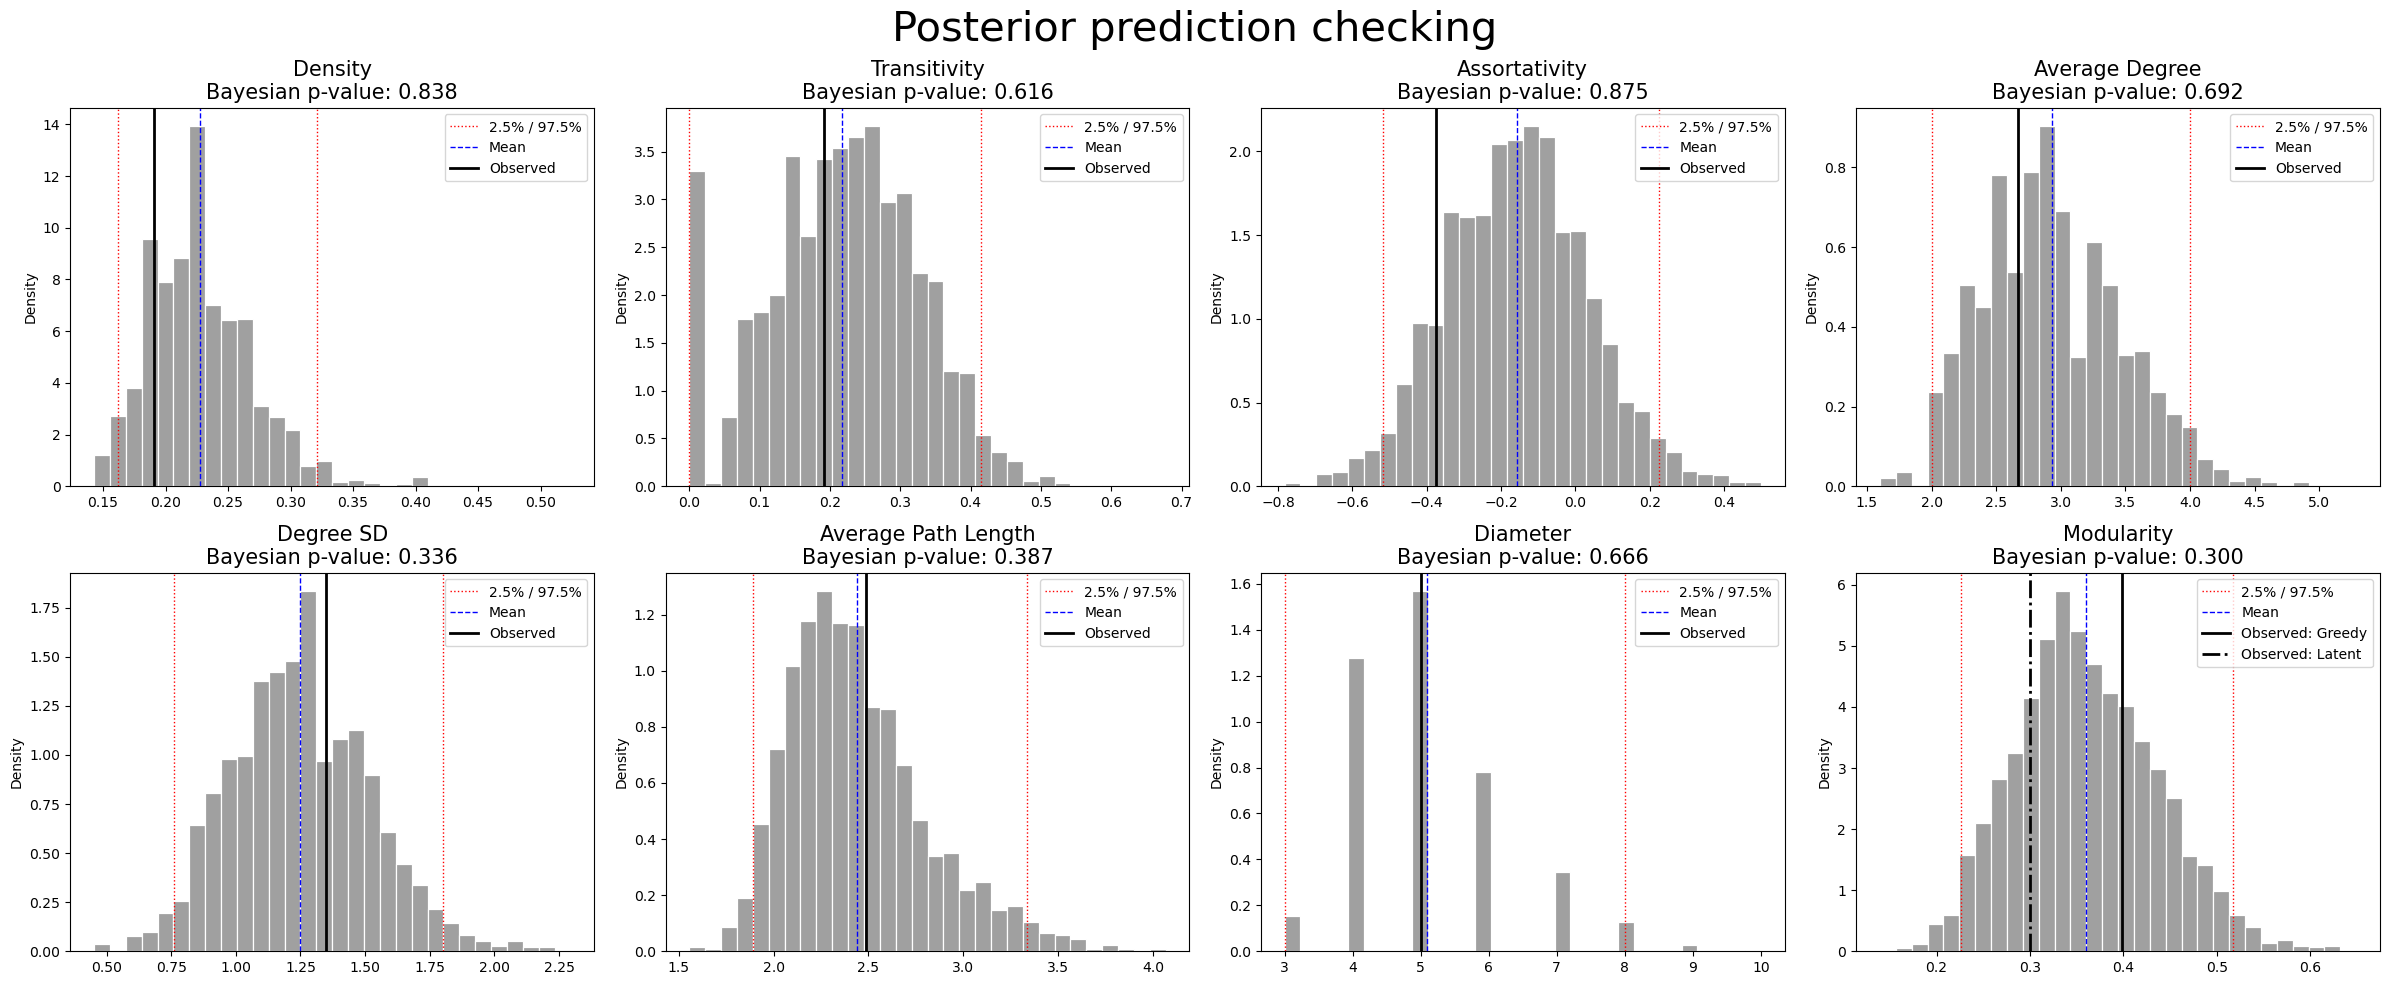

In [12]:
predictive_check(G,samples_Z,samples_a,samples_b)

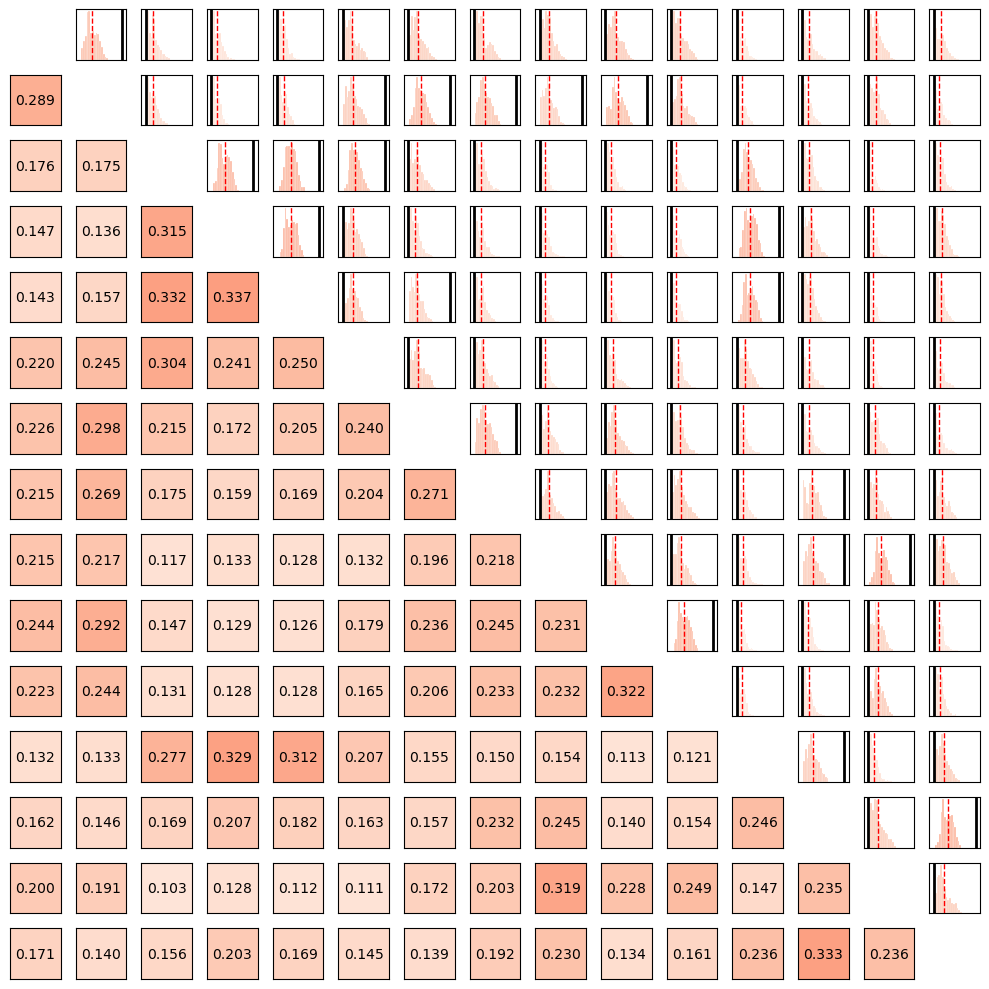

In [13]:
plot_pairwise_sociomatrix(G,samples_Z, samples_a, samples_b, Y)

#### Model comparison criteria

In [14]:
log_lik = compute_log_likelihood(Y, samples_Z, samples_a, samples_b)
waic = compute_WAIC(log_lik)
dic = compute_DIC_S1(log_lik, Y, samples_Z, samples_a, samples_b)


print(f"WAIC: {waic:.4f}")
print(f"DIC: {dic:.4f}")

WAIC: 202.2397
DIC: 189.4001


#### Prior predictive checking

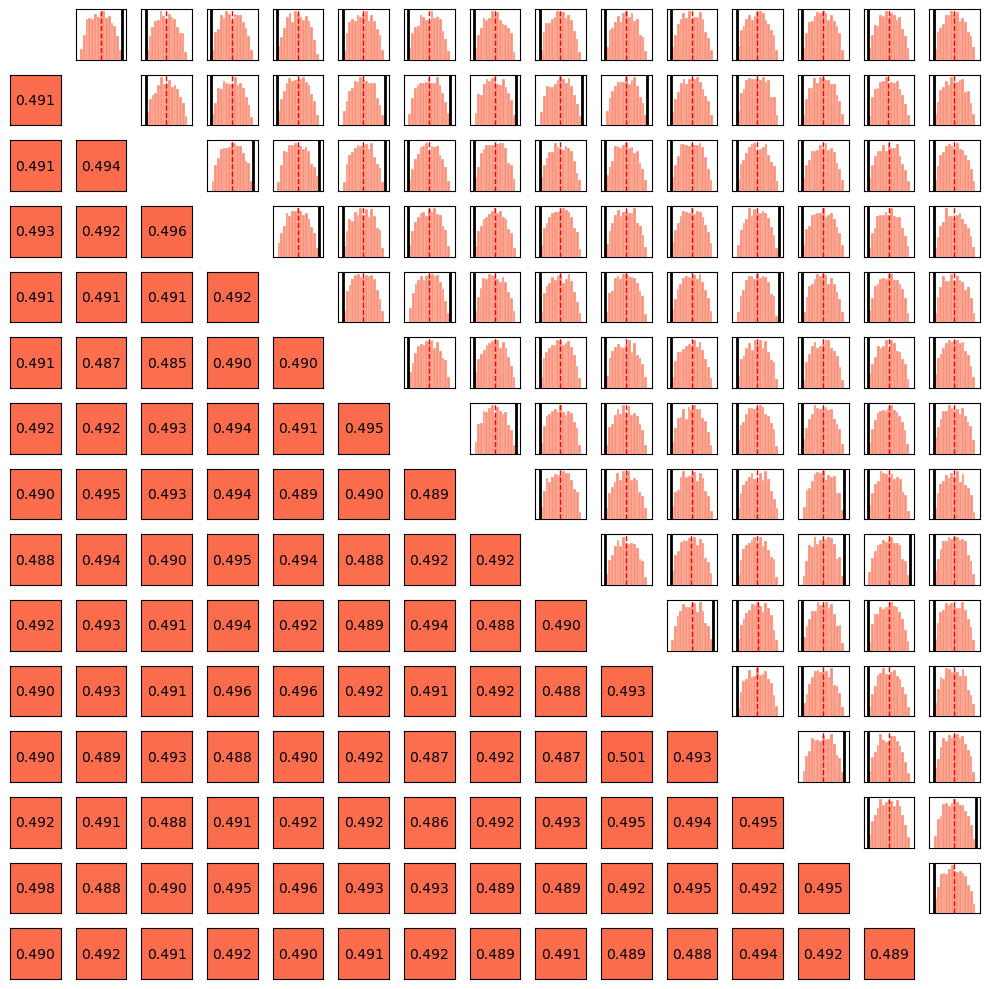

In [15]:
angles_prior = 2*np.pi*np.random.rand(number_of_samples, n)
samples_Z_prior = np.stack((np.cos(angles_prior), np.sin(angles_prior)), axis=2)
samples_a_prior = np.random.randn(number_of_samples)
samples_b_prior = np.random.randn(number_of_samples)
plot_pairwise_sociomatrix(G,samples_Z_prior, samples_a_prior, samples_b_prior, Y)

#### Prediction evaluation

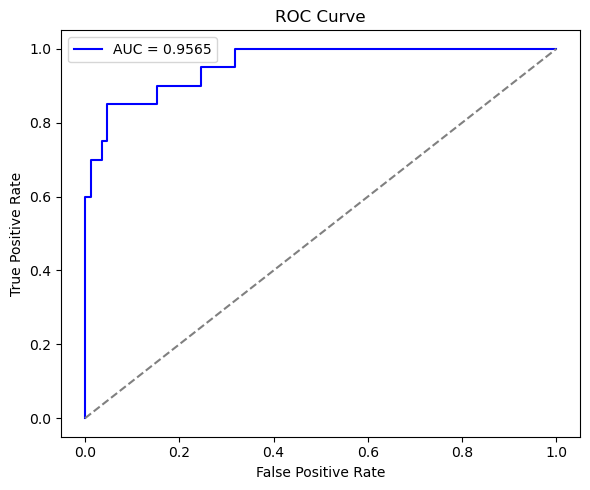

{'roc_auc': 0.9564705882352942,
 'confusion_matrix': {'tp': 0, 'tn': 85, 'fp': 0, 'fn': 20},
 'accuracy': 0.8095238095238095,
 'precision': 0.0,
 'recall': 0.0,
 'f1_score': 0.0,
 'specificity': 1.0}

In [16]:
roc_analysis(Y, posterior_connection_probs(samples_Z, samples_a, samples_b))

## References

[1]